In [1]:
import openai, configparser, json, re, psycopg2
from transformers import GPT2TokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.notebook import tqdm
from io import StringIO

#Get the API-key
config_obj = configparser.ConfigParser()
config_obj.read("config.ini")

keys = config_obj["OPENAI"]
openai.api_key = keys["API_KEY"]

pd.set_option('display.max_colwidth', None)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
database_logins = config_obj["POSTGRELOGINS"]

conn = psycopg2.connect(
    database="beers",
    user=database_logins['USERNAME'],
    password=database_logins['PASSWORD'],
    host=database_logins['HOST'],
    port=database_logins['PORT']
)

conn.autocommit = True

# GPT-3 Model
GPT-3 models can understand and generate natural language. 
There are four main models with different levels of power suitable for different tasks. Davinci is the most capable model, and Ada is the fastest. 

### Let's first create a completions function we can use to query the model:

In [3]:
def completions(prompt):
    '''
    This function will create an OpenAI completion engine, given the following keyword arguments.
    - engine: the model we whish to use
    - promt: our query for the model
    - temperature: do we need determinisic results or do
    '''

    # create a completion
    completion = openai.Completion.create(engine="text-davinci-002", 
                                          prompt=prompt,
                                          temperature=0,
                                          max_tokens=256,
                                          top_p=1,
                                          frequency_penalty=0,
                                          presence_penalty=0
                                         )

    # print the completion
    return completion.choices[0].text

## Example 1: Generate a spreadsheet with beer names
Let's ask GPT-3 to create us a spreadsheet with 10 beers, their alcohol percentage, brewer and color.

In [4]:
beers = completions("Create a 4 column spreadsheet with beer names, their alcohol percentage, "\
                    "brewery and color. With 10 rows.")

In [5]:
# Let's load these beers into a pandas DataFrame
csvStringIO = StringIO(beers)
beers = pd.read_csv(csvStringIO, sep="|")

# Remove spaces from column names
beers.columns = [i.strip() for i in beers.columns.to_list()]

# Remove the numbers from the beer names
beers['Name'] = beers['Name'].apply(lambda x: re.sub(r'\d.', '', x))

beers

,Name,Alcohol %,Brewery,Color
0,Budweiser,5%,Anheuser-Busch,Pale lager
1,Coors Light,4.2%,Coors Brewing Company,Pale lager
2,Miller Lite,4.2%,Miller Brewing Company,Pale lager
3,Corona Extra,4.6%,Grupo Modelo,Pale lager
4,Heineken,5%,Heineken International,Pale lager
5,Guinness Draught,4.2%,Guinness Brewery,Irish dry stout
6,Stella Artois,5%,Anheuser-Busch InBev,Belgian pale lager
7,Samuel Adams Boston Lager,4.9%,Boston Beer Company,American amber lager
8,Sierra Nevada Pale Ale,5.6%,Sierra Nevada Brewing Company,American pale ale
9,. Fat Tire Amber Ale,5.2%,New Belgium Brewing Company,American amber ale


## Example 2: Create product descriptions

### Beer Dataset
- First we will generate a static description based on the attributes from the beer.
- We will then use the description to generate a unique tagline by the AI.

In [6]:
def beer_percentages(p):
    if p < 4.8:
        return 'light'
    if p >= 4.8 and p < 7.05:
        return 'normal'
    if p >= 7.05 :
        return 'strong'
    
beers['Strong'] = beers['Alcohol %'].str.replace('%','').astype('float').apply(lambda x: beer_percentages(x))

In [7]:
descriptions = []
for index, row in beers.iterrows():
    description = f"The beer name is {row['Name']}. The brewery is {row['Brewery']}. The type is a {row['Color']}.\
    It is a {row['Strong']} beer. The alcohol percentage is {row['Alcohol %']}."
    descriptions.append(description)
    
beers['description'] = descriptions

In [8]:
beers[['description']]

,description
0,The beer name is Budweiser . The brewery is Anheuser-Busch . The type is a Pale lager. It is a normal beer. The alcohol percentage is 5% .
1,The beer name is Coors Light . The brewery is Coors Brewing Company . The type is a Pale lager. It is a light beer. The alcohol percentage is 4.2% .
2,The beer name is Miller Lite . The brewery is Miller Brewing Company . The type is a Pale lager. It is a light beer. The alcohol percentage is 4.2% .
3,The beer name is Corona Extra . The brewery is Grupo Modelo . The type is a Pale lager. It is a light beer. The alcohol percentage is 4.6% .
4,The beer name is Heineken . The brewery is Heineken International . The type is a Pale lager. It is a normal beer. The alcohol percentage is 5% .
5,The beer name is Guinness Draught . The brewery is Guinness Brewery . The type is a Irish dry stout. It is a light beer. The alcohol percentage is 4.2% .
6,The beer name is Stella Artois . The brewery is Anheuser-Busch InBev . The type is a Belgian pale lager. It is a normal beer. The alcohol percentage is 5% .
7,The beer name is Samuel Adams Boston Lager . The brewery is Boston Beer Company . The type is a American amber lager. It is a normal beer. The alcohol percentage is 4.9% .
8,The beer name is Sierra Nevada Pale Ale . The brewery is Sierra Nevada Brewing Company . The type is a American pale ale. It is a normal beer. The alcohol percentage is 5.6% .
9,The beer name is . Fat Tire Amber Ale . The brewery is New Belgium Brewing Company . The type is a American amber ale. It is a normal beer. The alcohol percentage is 5.2% .


In [9]:
responses = []

for description in beers['description']:
    input_text = f'Write a product discription for: {description}'
    #print(input_text)
    result = completions(input_text)
    #print(result)
    try:
        responses.append(result)
    except Exception as e:
        print(e)
        print(result)
        
beers['gpt_description'] = responses

In [10]:
beers[['gpt_description']].head(5)

,gpt_description
0,\n\nBudweiser is a pale lager that is brewed by Anheuser-Busch. It has an alcohol percentage of 5%. It is a normal beer.
1,"\n\nCoors Light is a light beer that is perfect for those who are looking to enjoy a refreshing beverage without the heaviness of a traditional beer. It has a 4.2% alcohol content, making it a great choice for those who are looking to enjoy a beer without getting too buzzed."
2,\n\nMiller Lite is a light beer from Miller Brewing Company. It is a pale lager with an alcohol percentage of 4.2%.
3,"\n\nCorona Extra is a light beer that is perfect for any occasion. It has a 4.6% alcohol content, making it a great choice for those who want to enjoy a beer without getting too drunk. The beer is brewed by Grupo Modelo, and is a pale lager. This means that it is a light beer with a slightly sweet taste."
4,\n\nHeineken is a pale lager that is brewed by Heineken International. The alcohol percentage is 5%. It is a normal beer.


## Example 3: Question Answering
Answers (/answers) is a dedicated question-answering endpoint useful for applications that require high accuracy text generations based on sources of truth like company documentation and knowledge bases. The additional context can be provided either as a list of up to 200 documents or as a pre-uploaded file to go beyond that limit.

In [11]:
beer_stock_dataset = pd.read_csv('datasets/beer_dataset.csv')

In [12]:
beer_stock_dataset

,Unnamed: 0,Name,Brewery,Type,Alcohol,Stock,Strong,Country
0,0,Aardbeien Lambic St. Louis,Van Honsebrouck,red,5.00%,18,normal,Belgium
1,1,Aarschotse Brown,De Biertoren,brown,4.00%,4,light,Belgium
2,2,Abbaye de Bonne-Esperance,Lefebvre,amber,8.00%,93,strong,Belgium
3,3,Abbaye de Brogne donker,De Smedt,unknown,6.70%,48,normal,Belgium
4,4,Abbaye de Cambron,Brasserie de Silly,amber,6.50%,72,normal,Belgium
...,...,...,...,...,...,...,...,...
685,685,Yperman,Het Sas/Leroy,unknown,6.00%,51,normal,Belgium
686,686,Zeelse houten kop,Huyghe,unknown,NaN,46,NaN,Belgium
687,687,Zottegems,Cromb,dark,4.50%,52,light,Belgium
688,688,Zottegemse Grand Cru,Cromb,unknown,8.40%,8,strong,Belgium


In [14]:
with open('datasets/beer_stock.jsonl', 'w+') as f:
    for index, row in beer_stock_dataset.iterrows():
        description = f"The beer name is {row['Name']}. The brewery name is {row['Brewery']}. The color is {row['Type']}. There are {row['Stock']} items in stock. It's a {row['Strong']} beer."
        f.write(json.dumps({"text": description}) + '\n')

In [15]:
openai.File.create(file=open("datasets/beer_stock.jsonl"), purpose='answers')

<File file id=file-jVGzSbVxvaiCeO2J2JH8bSoK at 0x7f5b1e770900> JSON: {
  "bytes": 100920,
  "created_at": 1653296569,
  "filename": "file",
  "id": "file-jVGzSbVxvaiCeO2J2JH8bSoK",
  "object": "file",
  "purpose": "answers",
  "status": "uploaded",
  "status_details": null
}

In [20]:
result = openai.Answer.create(
    search_model="ada", 
    model="curie", 
    question="What's the color of the Aardbeien Lambic St. Louis from Van Honsebrouck ?", 
    file="file-jVGzSbVxvaiCeO2J2JH8bSoK", 
    examples_context="The beer name is Abdijbier Sint-Idesbald trippel. The brewery name is Damberd. "\
    "The color is brown. There are 91 items in stock. It's a strong beer.", 
    examples=[["Give me the color from Abdijbier Sint-Idesbald trippel from Damberd", \
               "The color of hte beer is brown."]], 
    max_rerank=1,
    max_tokens=10,
    stop=["\n", "<|endoftext|>"]
)

result.answers[0]

'The color of the beer is red.'

# Codex Model 
The Codex models are descendants of the GPT-3 models that can understand and generate code. Their training data contains both natural language and billions of lines of public code from GitHub.

They’re most capable in Python and proficient in over a dozen languages including JavaScript, Go, Perl, PHP, Ruby, Swift, TypeScript, SQL, and even Shell.
## Example 1: Translate natural language to SQL Queries


In [34]:
def codex_model(question):
    '''
    Here we use the Python API to call de Codex model. 
    The code-davinci-002 is the most capable engine for generating code
    '''
    response = openai.Completion.create(
        engine="code-davinci-002",
        prompt=question,
        temperature=0,
        max_tokens=150,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0,
        stop=["#", ";"])
    
    return response.choices[0].text.strip()
    

In [67]:
# Ask you question
question = 'Show me how many beers from the type brown are sold per brewery. With more then 5 beers'

In [68]:
cursor = conn.cursor()
# We define the table structure so the codex model knows how to write the query
prompt_input = f'''
### PostgreSQL tables, with their properties:
#
# inventory(Name, Brewery, Type, Alcohol, Stock, Strong, Country)
#
### {question}
SELECT
'''

query = 'SELECT ' + codex_model(prompt_input)
print(query, '\n')
cursor.execute(query)
df = pd.DataFrame(cursor.fetchall())
df.columns = [desc[0] for desc in cursor.description]
print([desc[0] for desc in cursor.description])
df

SELECT Brewery,
    COUNT(Name) AS "Number of beers"
FROM
    inventory
WHERE
    Type = 'brown'
GROUP BY
    Brewery
HAVING
    COUNT(Name) > 5 

['brewery', 'Number of beers']


,brewery,Number of beers
0,Alken-Maes,15
1,Moortgat,6
2,Piedboeuf,9
3,Roman,7
4,Slaghmuylder,7


In [69]:
cursor.close()

## Example 2: Generate Python code based on natural language
The result from the above query is stored in a dataframe named df, let's ask our model to create code to sort the dataframe alphabetically.

In [70]:
question = 'Create a function that generates a seaborn bar plot for a given dataframe.' \
'The first column should be on the y axis and the second column on the x axis.#'

def bar_plot(df):
    sns.barplot(x=df.columns[1], y=df.columns[0], data=df)
    plt.show()

bar_plot(df)


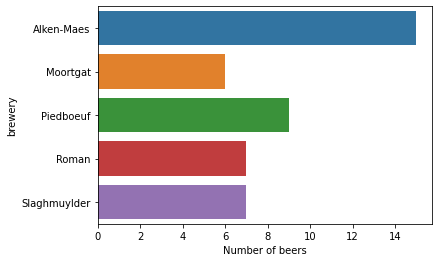

In [71]:
generated_code = codex_model(question)
print(generated_code)
exec(generated_code)

## Example 3: Write a Python docstring for a function
We specify the Python version, paste in the code, and then ask within a comment for a docstring, and give a characteristic beginning of a docstring (""").

In [75]:
question = '# Create a high-quality docstring for the above function#'
print(codex_model(question))

def get_user_input():
    """
    This function prompts the user for a number and returns it.
    """
    return int(input("Enter a number: "))
